In [1]:
import json

with open('data.json') as fp:
    data = json.load(fp)

data[:5]  # Close value every 30 minutes

[7.8e-07, 7.8e-07, 7.7e-07, 7.7e-07, 7.8e-07]

In [2]:
import math

group_length = 10
normalised_group_length = 4
groups = []

def normalise(group):
    reduced = [group[0], group[5], *group[7:]]
    mi, ma = (min(reduced), max(reduced))
    if mi == ma:
        return [0] * len(reduced)
    return [
        (val - mi) * (1 / (ma - mi))
        for val in reduced
    ]

for group in range(len(data) - group_length):
    groups.append(normalise(data[group:group + group_length]))

xs = [g[0:normalised_group_length] for g in groups]
ys = [g[normalised_group_length] for g in groups]

print('groups', xs[:5])
print('labels', ys[:5])

groups [[1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.5, 1.0], [0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0]]
labels [1.0, 1.0, 0.0, 1.0, 0.0]


In [3]:
from sklearn.model_selection import train_test_split as tts

train_x, test_x, train_y, test_y = tts(xs, ys, test_size=0.10)

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model = Sequential([
    Dense(normalised_group_length, input_shape=(normalised_group_length,)),
    Dense(1),
])

model.compile(optimizer='sgd', loss='mse')

Using TensorFlow backend.


In [5]:
import numpy as np
model.fit(
    x=np.array(train_x),
    y=np.array(train_y),
    epochs=1
)

Epoch 1/1
32583/32583 [==============================] - 1s 32us/step - loss: 0.2539


In [6]:
correct, wrong, error = 0, 0, 0

for x, y in zip(test_x, test_y):
    prediction = model.predict(np.array([x]))[0] < x[-1]
    actual = y < x[-1]
    
    error += abs(model.predict(np.array([x]))[0] - y) ** 2
    correct += actual == prediction
    wrong += actual != prediction

error /= len(test_x)
    
print('neural network score')
print('correct', correct, 'wrong', wrong, 'percentage', (correct/len(test_x)) * 100, 'mse', error)

neural network score
correct [2598] wrong [1023] percentage [71.74813587] mse [0.21145713]


In [7]:
from sklearn.svm import SVR

classifier = SVR(max_iter=2000)
classifier.fit(np.array(train_x), np.array(train_y))

/home/fabio/devel/digits/venv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=2000, shrinking=True, tol=0.001, verbose=False)

In [8]:
correct, wrong, error = 0, 0, 0

for x, y in zip(test_x, test_y):
    prediction = classifier.predict(np.array([x]))[0] < x[-1]
    actual = y < x[-1]
    
    error += abs(classifier.predict(np.array([x]))[0] - y) ** 2
    correct += actual == prediction
    wrong += actual != prediction

error /= len(test_x)

print('support vector machine score')
print('correct', correct, 'wrong', wrong, 'percentage', (correct/len(test_x)) * 100, 'mse', error)

support vector machine score
correct 2618 wrong 1003 percentage 72.30046948356808 mse 0.21839926052225705


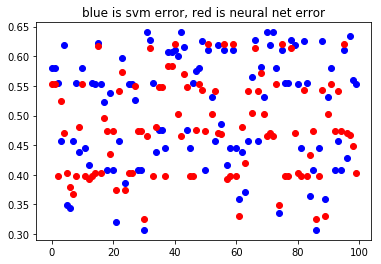

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

svm_error = []
neural_error = []
for x, y in list(zip(test_x, test_y))[:100]:
    svm_error.append(classifier.predict(np.array([x]))[0])
    neural_error.append(model.predict(np.array([x]))[0])

plt.title('blue is svm error, red is neural net error')
plt.plot(range(100), svm_error, 'bo')
plt.plot(range(100), neural_error, 'ro')